# Importing the libraries

In [2]:
import keras
import tensorflow_hub as hub
import tensorflow as tf
from keras import layers
import numpy as np
import pandas as pd
import datetime
import os
import pandas as pd

# Declaring constants

In [1]:
IMG_SIZE = 224
MAX_SEQUENCE_LEN = 32
NUM_OF_CHANNELS = 3

# Building the model
Code from https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb#scrollTo=8PXw88Y1_s2x

In [5]:
class EmotionRecognitionModel(tf.keras.Model):
    def __init__(self, classes):
        super(EmotionRecognitionModel, self).__init__()
        self.feature_extractor = hub.KerasLayer("https://tfhub.dev/shoaib6174/swin_small_patch244_window877_kinetics400_1k/1")
        self.feature_extractor.trainable = False
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(len(classes), activation="softmax")
        inputs = tf.keras.layers.Input(shape=(NUM_OF_CHANNELS, MAX_SEQUENCE_LEN, IMG_SIZE, IMG_SIZE))
       
        x = inputs
        x = self.feature_extractor(inputs)
        x = self.flatten(x)
        outputs = self.dense(x)
        self.model = tf.keras.Model(inputs, outputs)
    
    def call(self, inputs):
        return self.model(inputs)



In [6]:
train_df =  pd.read_csv(os.path.join("data", "train.csv"))
classes = np.unique(train_df["emotion"].values)
transformer_model = EmotionRecognitionModel(classes)

LR = 1e-3
transformer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
transformer_model.build(input_shape=(None, NUM_OF_CHANNELS, MAX_SEQUENCE_LEN, IMG_SIZE, IMG_SIZE))
transformer_model.summary()

Model: "emotion_recognition_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 768, 16, 7, 7)     53197014  
                                                                 
 flatten (Flatten)           (None, 602112)            0         
                                                                 
 dense (Dense)               (None, 6)                 3612678   
                                                                 
 model (Functional)          (None, 6)                 56809692  
                                                                 
Total params: 56,809,692
Trainable params: 3,612,678
Non-trainable params: 53,197,014
_________________________________________________________________


# Training

In [ ]:
t_df = tf.data.Dataset.load(os.path.join("data", "prepared_train_dataset")).map(lambda vid, label: (tf.cast((vid / 255.0), tf.float32), label))
v_df = tf.data.Dataset.load(os.path.join("data", "prepared_validation_dataset")).map(lambda vid, label: (tf.cast((vid / 255.0), tf.float32), label))


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

filepath = "/tmp/emotion_classifier"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

EPOCH_NUM = 10
BATCH_SIZE = 16
SHUFFLE_BUFFER = 200
transformer_model.fit(x=t_df.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE), epochs=EPOCH_NUM, validation_data=v_df.batch(BATCH_SIZE), callbacks=[checkpoint, tensorboard_callback])

# Inference

In [3]:
from image_processing import create_label_processor, preprocess_video

In [4]:
train_df = pd.read_csv(os.path.join("data", "train.csv"))
label_processor = create_label_processor(np.unique(train_df["emotion"]))
label_vocab = label_processor.get_vocabulary()

def get_label_for_prediction(prediction):
    return label_vocab[np.argmax(prediction)]


In [ ]:
transformer_model.load_weights("weights\emotion_classifier")

In [5]:
model = tf.keras.models.load_model('model')

In [6]:
def predict_video(path, model):
    video, mask = preprocess_video(path)
    video = video[None, ...]
    video = tf.cast(video, tf.float32)
    video = video / 225
    prediction = model.predict(video)
    return prediction

print(f"label: {get_label_for_prediction(predict_video(path=os.path.join('data', 'VideoFaceEmotion', 'test', 'test001.avi'), model=model))}")
#transformer_model.predict()

Start data\VideoFaceEmotion\test\test001.avi
1/1 [==============================] - 10s 10s/step
label: anger


In [78]:
transformer_model.save("model", save_format="tf")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


## Creating the test dataset

In [18]:
test_df = pd.DataFrame()
test_videos = os.listdir(os.path.join('data', 'VideoFaceEmotion', 'test'))
test_df["video_name"] = test_videos
test_df["video_path"] = os.path.join('data', 'VideoFaceEmotion', 'test', "") + test_df["video_name"]

In [20]:
test_df.to_csv(os.path.join("data", "test.csv"), index=False)

## Inference on the test dataset 

In [22]:
test_df["prediction"] = test_df["video_path"].apply(lambda path: get_label_for_prediction(predict_video(path=path, model=model)))


Start data\VideoFaceEmotion\test\test001.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test002.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test003.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test004.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test005.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test006.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test007.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test008.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test009.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test010.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test011.avi
1/1 [

1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test088.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test089.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test090.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test091.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test092.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test093.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test094.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test095.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test096.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test097.avi
1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test174.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test175.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\test\test176.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\test\test177.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test178.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test179.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test180.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test181.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test182.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test183.avi
1/1 [==============================] - 6s 6s/step


1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test260.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test261.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test262.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test263.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test264.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test265.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test266.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test267.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test268.avi
1/1 [==============================] - 6s 6s/step
Start data\VideoFaceEmotion\test\test269.avi
1/1 [==============================] - 6s 6s/step


In [42]:
test_df_copy = test_df.copy()
test_df_copy["File"] = test_df_copy["video_name"].apply(lambda name: name.split(".")[0])
test_df_copy["Label"] = test_df_copy["prediction"].apply(lambda label: label[0].upper() + label[1:])

In [44]:
test_df_copy = test_df_copy[["File", "Label"]]

In [45]:
test_df_copy.to_excel(os.path.join("predictions", "prediction.xlsx"), index=False)

# Evaluation

In [7]:
validation_df = pd.read_csv(os.path.join("data", "validation.csv"))

In [8]:
validation_df["prediction"] = validation_df["video_path"].apply(lambda path: get_label_for_prediction(predict_video(path=path, model=model)))


Start data\VideoFaceEmotion\train\Anger\trainAnger002.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger003.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger006.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger011.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger019.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger021.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger022.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger030.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Anger\trainAnger033.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\

1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise011.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise015.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise021.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise035.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise040.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise051.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise052.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surprise\trainSurprise055.avi
1/1 [==============================] - 5s 5s/step
Start data\VideoFaceEmotion\train\Surp

Classification report on 'validation' dataset
              precision    recall  f1-score   support

       anger       0.93      0.87      0.90        15
     disgust       1.00      0.64      0.78        14
        fear       0.91      0.71      0.80        14
   happiness       0.81      0.87      0.84        15
     sadness       0.57      0.93      0.70        14
    surprise       1.00      0.93      0.96        14

    accuracy                           0.83        86
   macro avg       0.87      0.82      0.83        86
weighted avg       0.87      0.83      0.83        86



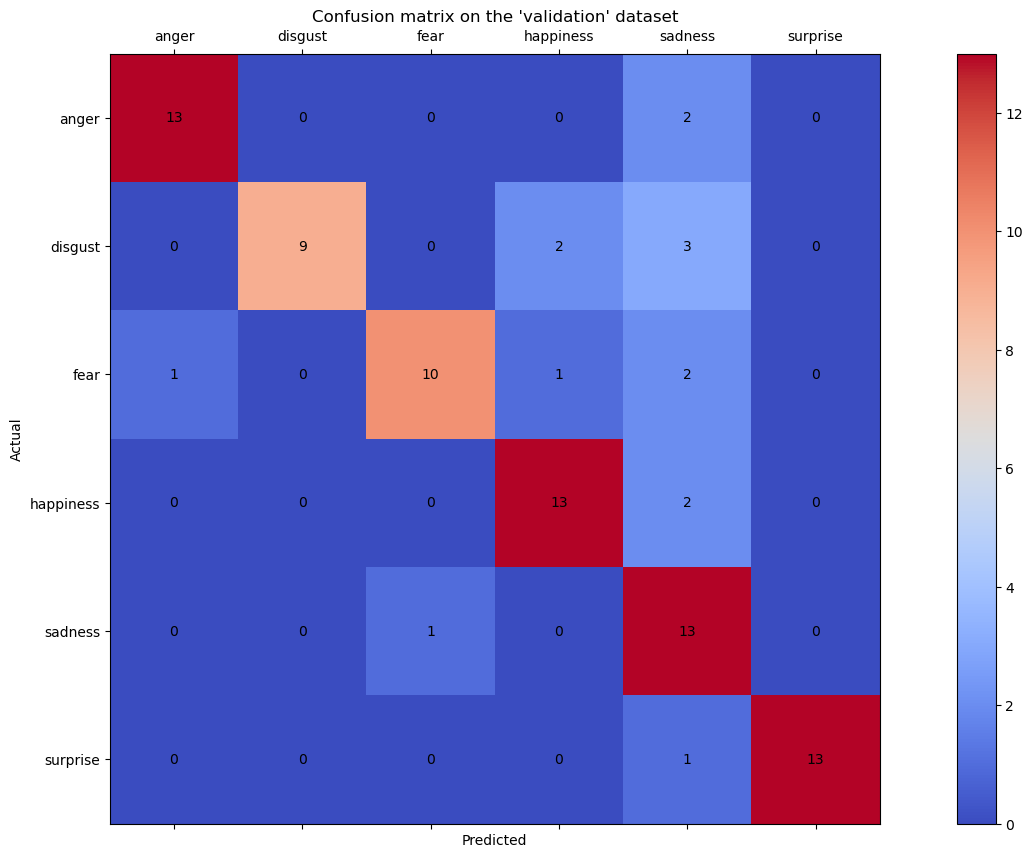

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def get_classification_report(actual_labels, predicted_labels, labels):
    return classification_report(actual_labels.tolist(), predicted_labels.tolist(), target_names=sorted(labels))

def plot_confusion_matrix(cm, labels, dataset):
    fig, ax = plt.subplots()
    matrix = ax.matshow(cm, interpolation="nearest", cmap="coolwarm")

    for (x, y), value in np.ndenumerate(cm.T):
        ax.text(x, y, str(value),  ha='center', va='center')
    fig.colorbar(matrix)
    ax.set_xticks([i for i in range(len(labels))])
    ax.xaxis.set_ticklabels(sorted(labels))
    ax.set_yticks([i for i in range(len(labels))])
    ax.yaxis.set_ticklabels(sorted(labels))
    plt.title(f"Confusion matrix on the '{dataset}' dataset")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    fig.set_size_inches(20, 10)
    plt.show()

    
labels = label_processor.get_vocabulary()
actual_labels = validation_df["emotion"].values
predicted_labels = validation_df["prediction"].values
eval_dataset = "validation"

print(f"Classification report on '{eval_dataset}' dataset")
print(get_classification_report(actual_labels, predicted_labels, labels))
cm = confusion_matrix(actual_labels.tolist(), predicted_labels.tolist())
plot_confusion_matrix(cm, labels, eval_dataset)